# Improved SCA based on SVM
---

In previous notebooks, we trained and attacked the same device. While this is useful for understanding the principles, the goal of a profiled attack is to successfully execute it on a different device.

In this notebook, we will use our trained models to attack traces recorded from another CW Nano.

`Note:` Make sure you completed:
- &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`11_attack_HW_model`
- &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`21_attack_BIT_model`

---

#### Importing attack traces and models
We saw in `sca101/Lab 4_2 - CPA on Firmware Implementation of AES` that only 200 traces from the CW Nano were needed to break the encryption. Therefore, we will set 200 traces as our threshold. If our model fails to recover the key using 200 traces or fewer, we will consider the attack unsuccessful.

In [2]:
import chipwhisperer as cw
import numpy as np

In [70]:
byte_index = 0
threshold = 200

print(f'We are attacking byte {byte_index} with trace threshold of {threshold} traces')

We are attacking byte 0 with trace threshold of 200 traces


In [12]:
import joblib

project_file = 'SCA_SVM_DATA/Included/traces/different_attack_traces.cwp'

project = cw.open_project(project_file)
traces = np.array(project.waves)
textins = project.textins
unknown_key = project.keys[0][byte_index]
hex_unknown_key = hex(unknown_key)

print(f'✅ Loaded {len(traces)} traces and textins with the unknown key {hex_unknown_key}')

✅ Loaded 1000 traces and textins with the unknown key 0xc4


In [13]:
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

In [82]:
import matplotlib.pyplot as plt

# This shows histogram of the guesses
def histogram(k_counters):
    plt.figure(figsize=(12, 6))
    
    # Convert indices to hex labels
    hex_labels = [f'0x{x:02X}' for x in range(256)]
    
    max_idx = np.argmax(k_counters)
    key_value = k_counters[unknown_key]
    special_idxs = sorted(set([max_idx, unknown_key]))  # Sort for correct x-axis order
    
    # Create x-ticks with special indices included
    tick_positions = list(range(0, 256, 16)) + special_idxs
    tick_labels = [hex_labels[i] for i in tick_positions]
    
    # Bar colors: red for special indices, green for bars higher than 0xC4, blue otherwise
    colors = [
        'red' if i in special_idxs else 'green' if k_counters[i] > key_value else 'royalblue' 
        for i in range(256)
    ]
    
    plt.bar(range(256), k_counters, color=colors)
    plt.xticks(tick_positions, tick_labels, rotation=45)
    
    # Highlight special indices in red on the x-axis
    ax = plt.gca()
    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        if tick in special_idxs:
            label.set_color('red')
            label.set_fontweight('bold')
    
    # Labels & Grid
    plt.xlabel("Key Guess (Hex)")
    plt.ylabel("Count")
    plt.title("Key Guess Histogram")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

## HW model

First we will test the the HW model.

---

#### 1. Import model

In [ ]:
# To use the included model
# model_file = 'SCA_SVM_DATA/Included/models/hw_model.pkl'

model_file = f'{project_folder}/models/hw_model.pkl'

model_data = joblib.load(model_file)
model = model_data['model']
p = model_data['p']

print(f'✅ Loaded the attack model')

✅ Loaded the attack model


In [15]:
def hamming_weight(value):
    return bin(value).count('1')

In [16]:
def get_k_counters_HW(T):
    t = traces[:T].T
    X = t[np.sort(p)].T
    predictions = model.predict(X)
    
    k_counters = np.zeros(256, dtype=int)
    for i,c in enumerate(predictions):
        for k in range(256):
            s = SBOX[textins[i][0]^k]
            hw = hamming_weight(s)
            if hw == c:
                k_counters[k]+=1
    return k_counters

#### 2. Execute
Previously, we successfully recovered the key using just 4 traces. Let's try that again!

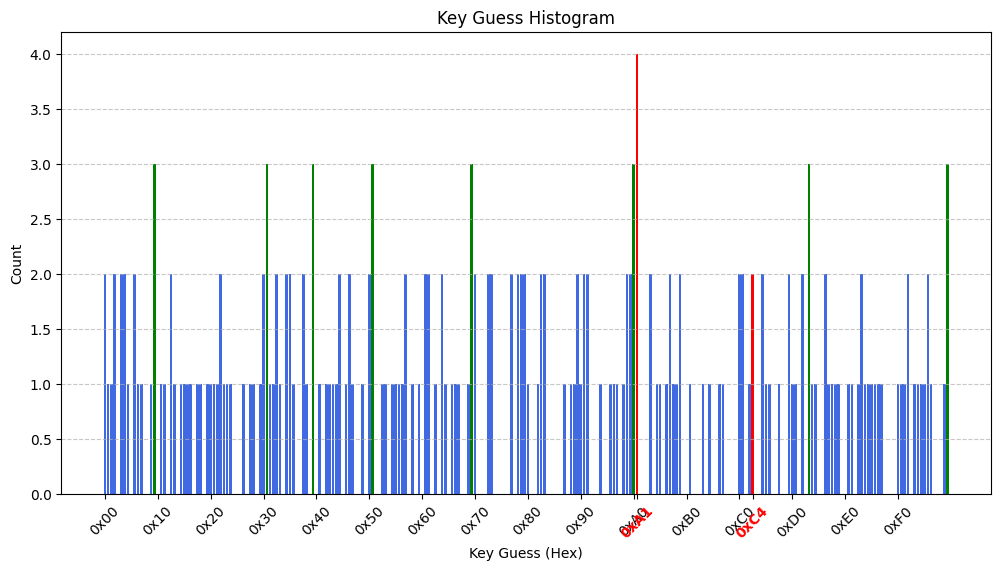

In [83]:
k_counters = get_k_counters_HW(4)
histogram(k_counters)

#### 😕 Bad news!
Looks like 4 traces aren’t enough this time. Let’s try 15:

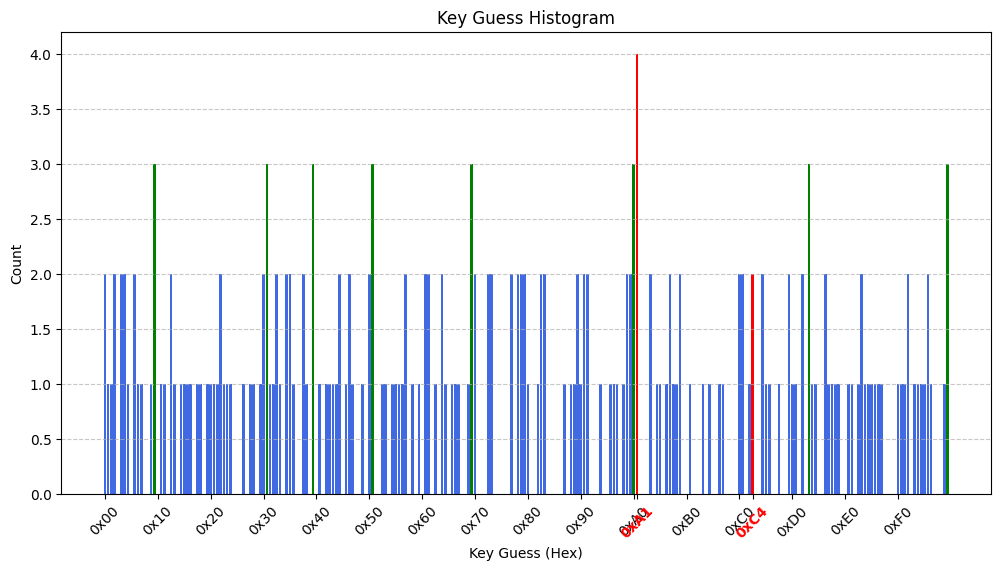

In [84]:
k_counters = get_k_counters_HW(4)
histogram(k_counters)

It looks like 15 traces still aren’t enough. Feel free to experiment with different values, but I’ll jump straight to the threshold.

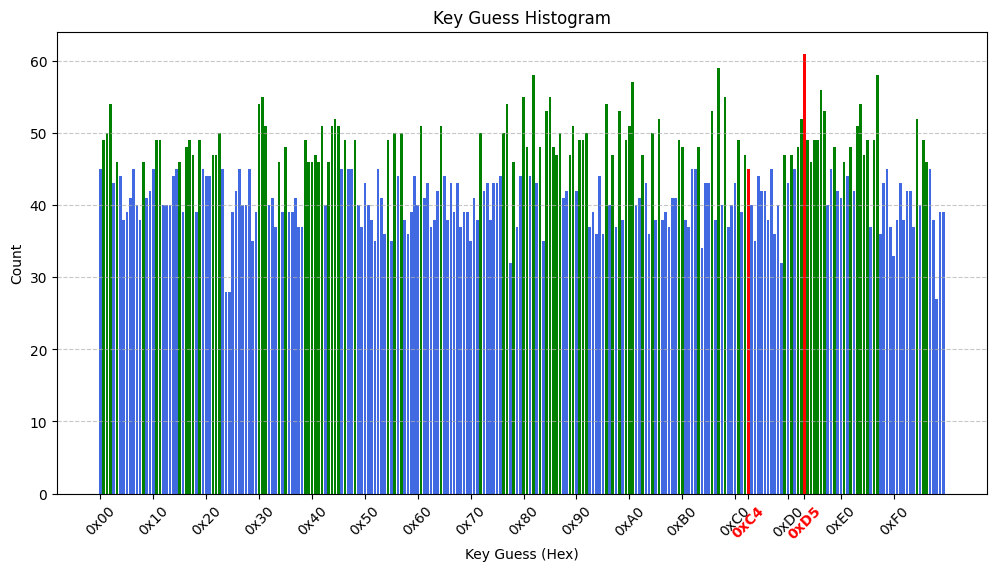

In [85]:
k_counters = get_k_counters_HW(threshold)
histogram(k_counters)

Unfortunately, the model fails to break the encryption even with the maximum number of traces.

In this setup, we can "cheat" by directly measuring the success rate of the model:

In [112]:
t = traces.T
X = t[np.sort(p)].T
predictions = model.predict(X)

success = 0
fail = 0
for i,c in enumerate(predictions):
    s = SBOX[textins[i][0]^unknown_key]
    hw = hamming_weight(s)
    if hw == c:
        success+=1
    else:
        fail+=1
        
print(f'The Hamming Weight model has {success/fail:.2f} success rate')

The Hamming Weight model has 0.28 success rate


As expected, the success rate is very low, meaning most of the predictions are incorrect, which leads to an incorrect key.

---

Next, we'll try the Bit model and see if it performs any better.

## Bit model
We will use our improved bit model, which leverages Hamming Distance for better accuracy.

#### 1. Import models

In [113]:
from scipy.stats import pearsonr

# Compute Pearson correlation for each trace point.
def pearson_corr(X, y):
    return np.array([ abs(pearsonr(X[:, i], y)[0]) for i in range(X.shape[1])])

In [ ]:
# To use the included models

models_data = []
for bit in range(8):
    model_file = f'SCA_SVM_DATA/Included/models/bit{bit}_model.pkl' ## CHANGE LATER
    model_data = joblib.load(model_file)
    models_data.append(model_data)
print(f'✅ Loaded the attack models')

✅ Loaded the attack models


In [ ]:
# To use your own models

model_folder = f'{project_folder}/models'

models_data = []
for bit in range(8):
    model_file = f'{model_folder}/bit{bit}_model.pkl'
    
    model_data = joblib.load(model_file)
    models_data.append(model_data)

print(f'✅ Loaded the attack models')

In [117]:
def get_bit(value, bit_pos):
    return (value >> bit_pos) & 1

In [118]:
def bits_to_number(bits):
    number = 0
    for bit in bits:
        number = (number << 1) | bit  # Left-shift and OR
    return number

In [119]:
def hamming_distance(num1, num2):
    return bin(num1 ^ num2).count('1')

In [120]:
def get_k_counters_HD(T):
    predictions = []
    for bit in range(8):
        model_data = models_data[bit]
        model = model_data['model']
        N = model_data['N']
        selector = model_data['selector']
        features = selector.transform(traces[:T])[:,:N]
        predictions.append(model.predict(features))
        
    predictions = np.array(predictions)
    predicted_numbers = predictions[::-1].T

    k_counters = np.zeros(256, dtype=int)
    for i in range(T):
        for K in range(256):
            P = textins[i][0]
            s = SBOX[K^P]
            c = bits_to_number(predicted_numbers[i])
            if s == c or hamming_distance(s,c)<=1:
                k_counters[K]+=1

    return k_counters

#### 2. Execute
Previously, we successfully recovered the key using just 4 traces. Let's try that again!

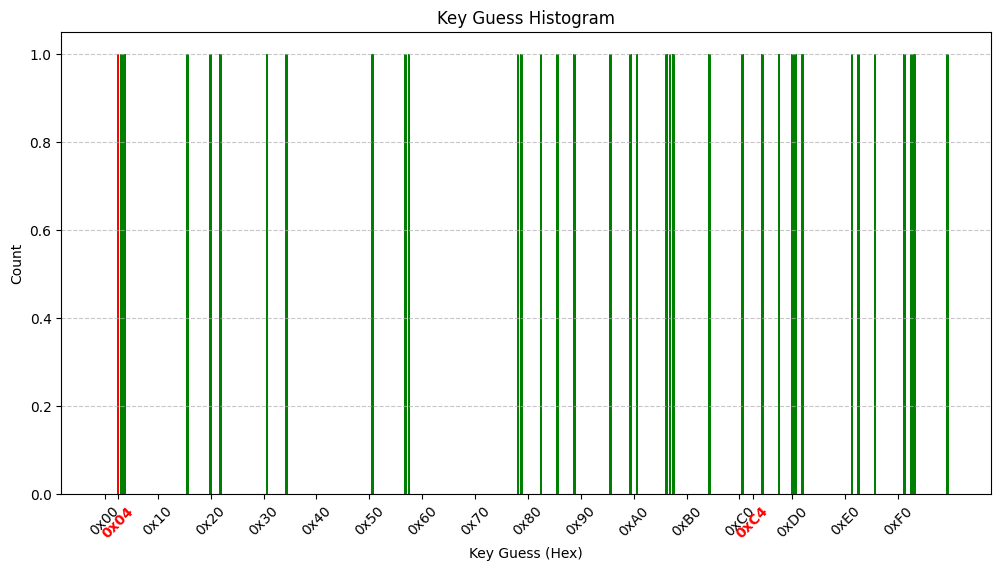

In [121]:
k_counters = get_k_counters_HD(4)
histogram(k_counters)

#### 😕 Oops!
It looks like 4 traces aren't enough. the correct key didn't even get a single vote!

Let’s try 15:

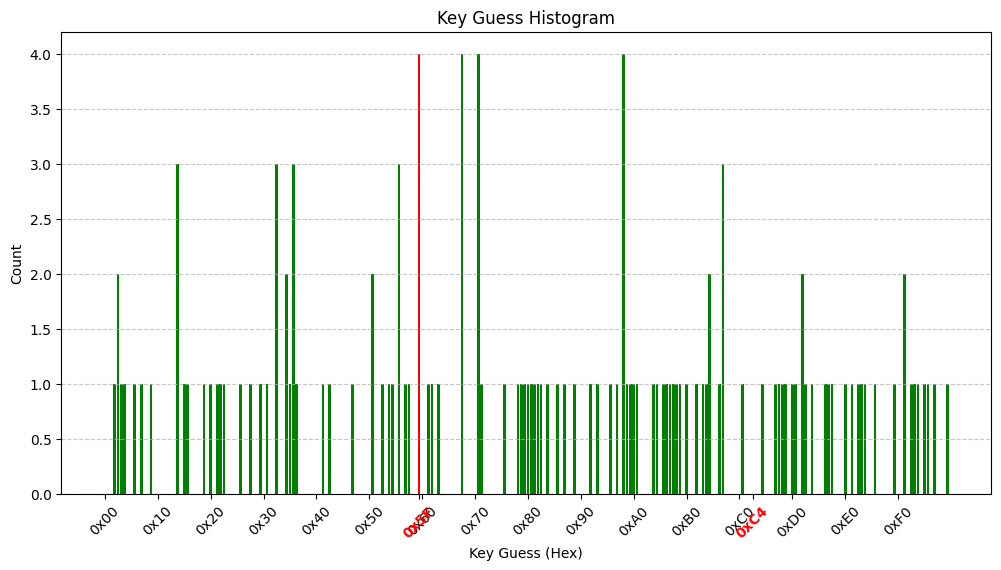

In [122]:
k_counters = get_k_counters_HD(15)
histogram(k_counters)

Once again, 15 traces aren't enough to recover the key, and there are no votes for the correct key.

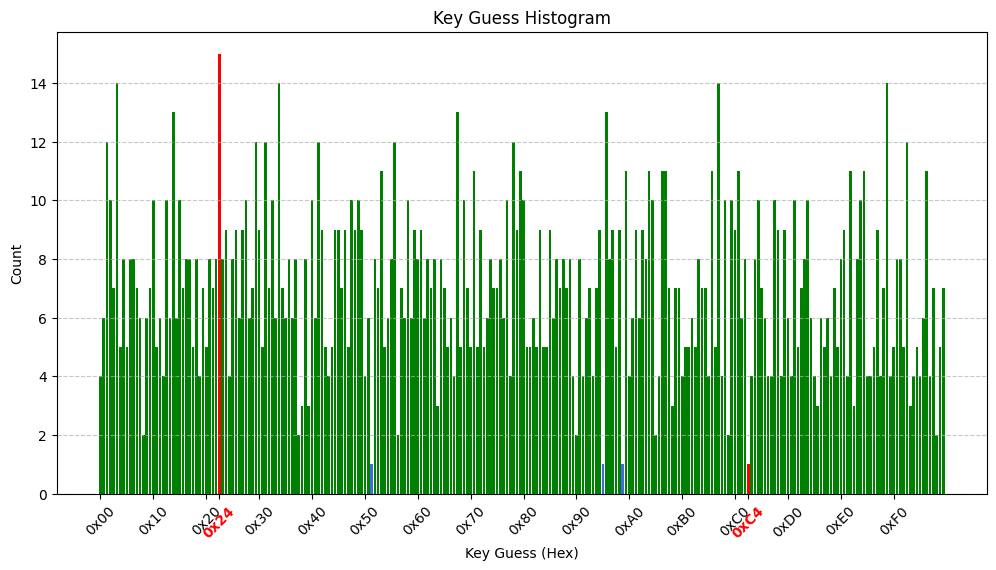

In [123]:
k_counters = get_k_counters_HD(threshold)
histogram(k_counters)

Finally, even when using the threshold amount of traces, the correct key barely receives a vote.

---

## Discussion

It is clear that the attack does not work when executed on a different device.

Despite using multiple traces, the model is unable to recover the key, which highlights the challenge of applying a profiled attack to a new device.

This suggests that either the model's generalization capabilities are insufficient or the differences between the devices are too significant for the attack to succeed.

Unfortunately in this case the findings render the attack useless and it’s better to explore other methods, although this attack may as well work efficiently when implemented on a different platform.